In [3]:
!pip install seqeval wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import warnings
warnings.filterwarnings("ignore", message=".*seems not to be NE tag.*")
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from collections import defaultdict
import random

seed = 7

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import gc
from tqdm.auto import tqdm


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
#INIT
NUM_EPOCHS = 100
RUN_NAME = 'ankh-cnnlstm-plateau-bz32'
LEARNING_RATE = 0.01
BATCH_SIZE = 32
# PROJECT_NAME = 'thesis-ankh'
PROJECT_NAME = 'tesis' #for trial
SCH_PATIENCE = 2
SCH_FACTOR = 0.01

## Setup

In [6]:
print(torch.__version__)

2.2.0a0+81ea7a4


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Available device:', device)
def check_len(some_list):
    for i in some_list:
        print(len(i))


def get_num_params(model):
    return sum(p.numel() for p in model.parameters())


Available device: cuda:0


In [8]:

import wandb

wandb.login(key='a1fe436a6d0898d9291bc0f6bf47be62aea60bec')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kaylazima to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Load Dataset Processed

In [11]:
def extract_embeddings_only(npz_file, device='cpu'):
    """
    Extract only embeddings from NPZ file, ignoring chunk_start/chunk_end
    
    Args:
        npz_file: Path to NPZ file
        device: Target device ('cpu', 'cuda', etc.)
    
    Returns:
        torch.Tensor: Single concatenated tensor with all embeddings
    """
    embeddings_list = []
    
    with np.load(npz_file) as data:
        print(f"Processing {npz_file}...")
        
        # Find all embedding keys (ignore chunk_start/chunk_end)
        embedding_keys = [key for key in data.keys() if 'embeddings' in key]
        embedding_keys.sort()  # Sort to ensure consistent order
        
        print(f"Found embedding keys: {embedding_keys}")
        
        for key in embedding_keys:
            embedding_array = data[key]
            embedding_tensor = torch.from_numpy(embedding_array).to(device)
            embeddings_list.append(embedding_tensor)
            print(f"  {key}: {embedding_array.shape} -> {embedding_tensor.shape}")
    
    if embeddings_list:
        # Concatenate all embeddings along the first dimension (batch dimension)
        concatenated_embeddings = torch.cat(embeddings_list, dim=0)
        print(f"Final concatenated shape: {concatenated_embeddings.shape}")
        return concatenated_embeddings
    else:
        print("No embeddings found!")
        return None
    
def extract_embeddings_memory_efficient(npz_file, device='cpu', batch_size=1000):
    """
    Memory-efficient extraction of embeddings from NPZ file
    
    Args:
        npz_file: Path to NPZ file
        device: Target device ('cpu', 'cuda', etc.)
        batch_size: Process embeddings in batches to save memory
        
    Returns:
        torch.Tensor: Single concatenated tensor with all embeddings
    """
    
    # First pass: get total size and embedding keys
    with np.load(npz_file) as data:
        embedding_keys = [key for key in data.keys() if 'embeddings' in key]
        embedding_keys.sort()
        
        print(f"Found embedding keys: {embedding_keys}")
        
        # Calculate total size
        total_size = 0
        embedding_dim = None
        for key in embedding_keys:
            shape = data[key].shape
            total_size += shape[0]
            if embedding_dim is None:
                embedding_dim = shape[1:]
            print(f"  {key}: {shape}")
        
        print(f"Total embeddings: {total_size}, Dimension: {embedding_dim}")
    
    # Pre-allocate result tensor on target device
    final_shape = (total_size,) + embedding_dim
    result_tensor = torch.empty(final_shape, dtype=torch.float32, device=device)
    
    # Second pass: load and copy data in chunks
    current_idx = 0
    
    with np.load(npz_file) as data:
        for key in embedding_keys:
            embedding_array = data[key]
            num_embeddings = embedding_array.shape[0]
            
            print(f"Processing {key}: {embedding_array.shape}")
            
            # Process in batches to avoid memory spikes
            for start_idx in range(0, num_embeddings, batch_size):
                end_idx = min(start_idx + batch_size, num_embeddings)
                batch_data = embedding_array[start_idx:end_idx]
                
                # Convert to tensor and move to device immediately
                batch_tensor = torch.from_numpy(batch_data).to(device)
                
                # Copy to pre-allocated tensor
                result_tensor[current_idx:current_idx + batch_tensor.shape[0]] = batch_tensor
                current_idx += batch_tensor.shape[0]
                
                # Clean up
                del batch_tensor
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                print(f"  Processed {end_idx}/{num_embeddings} embeddings")
    
    print(f"Final tensor shape: {result_tensor.shape}")
    return result_tensor


In [19]:
input_path = './dataset/'
# train_seq = extract_embeddings_memory_efficient(input_path +  'train_sequence_Ankh.npz')
# train_labels = extract_embeddings_memory_efficient(input_path +  'train_labels_Ankh.npz')
# val_seq = extract_embeddings_memory_efficient(input_path +  'val_sequence_Ankh.npz')
# val_labels = extract_embeddings_memory_efficient(input_path +  'val_labels_Ankh.npz')
test_seq = extract_embeddings_only(input_path +  'test_sequence_Ankh.npz')
test_labels = extract_embeddings_only(input_path +  'test_labels_Ankh.npz')
train_seq = test_seq
train_labels = test_labels
val_seq = test_seq
val_labels = test_labels
id2tag = {1: 'L', 3: 'T', 8: 'G', 4: 'S', 6: 'B', 0: 'H', 5: 'E', 7: 'P', 2: 'I'}

Processing ./dataset/test_sequence_Ankh.npz...
Found embedding keys: ['embeddings']
  embeddings: (1213, 1, 108, 1536) -> torch.Size([1213, 1, 108, 1536])
Final concatenated shape: torch.Size([1213, 1, 108, 1536])
Processing ./dataset/test_labels_Ankh.npz...
Found embedding keys: ['embeddings']
  embeddings: (1213, 108, 9) -> torch.Size([1213, 108, 9])
Final concatenated shape: torch.Size([1213, 108, 9])


## Dataset loader

In [20]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def preprocessing_emb(X, y, test_size = 0, random_state = 42):
    # Convert to tensors if they're not already
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    if not isinstance(y, torch.Tensor):
        y = torch.LongTensor(y)

    return X, y
    
def create_dataloaders(X_train, y_train, X_val, y_val, batch_size=32):
    """
    Create train and validation DataLoaders from your data

    Args:
        X_train, X_val: Input data tensor (N, sequence_length, features)
        y_train, y_val: Target labels tensor (N,) or (N, sequence_length, n_classes)
        batch_size: Batch size for DataLoader

    Returns:
        train_loader, val_loader
    """

    # Preprocess the data
    X_train, y_train = preprocessing_emb(X_train, y_train)
    X_val, y_val = preprocessing_emb(X_val, y_val)


    # Create datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 for debugging, increase for faster loading
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    return train_loader, val_loader

In [21]:

# X_train = train_seq.to(device)
# y_train = train_labels.to(device)
# X_val = val_seq.to(device)
# y_val = val_labels.to(device)
# Create DataLoaders

train_loader, val_loader = create_dataloaders(train_seq, train_labels, val_seq, val_labels, batch_size=BATCH_SIZE)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 76
Number of validation batches: 76


# Training Configuration

In [22]:
import torch
import torch.nn as nn
class TimeDistributedLinear(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear = nn.Linear(input_features, output_features)
    
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_features]
        if x.dim() == 4:
            batch_size, channels, seq_len, features = x.size()
            # Reshape to 3D by combining batch and channels
            x = x.view(batch_size * channels, seq_len, features)
        else:
            batch_size, seq_len, features = x.size()
        
        # Reshape to apply linear layer
        x = x.view(-1, input_features)  # [batch_size * seq_len, input_features]
        x = self.linear(x)              # [batch_size * seq_len, output_features]
        
        # Reshape back to sequence format
        x = x.view(batch_size, seq_len, -1)  # [batch_size, seq_len, output_features]
        return F.softmax(x, dim=-1)


class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, n_classes, filter_size, convs, dense_size,
                 lstm_size, dropout_rate):
        super(CNNLSTMModel, self).__init__()

        self.batch_norm_input = nn.BatchNorm1d(input_dim)

        # Convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(input_dim, filter_size, conv, padding=conv//2),
                nn.ReLU(),
                nn.BatchNorm1d(filter_size)
            ) for conv in convs
        ])

        # Calculate size after concatenation
        self.concat_size = input_dim + len(convs) * filter_size

        # Fully connected layers
        self.dropout = nn.Dropout(dropout_rate)
        self.dense_conv = nn.Linear(self.concat_size, dense_size)
        self.batch_norm_dense = nn.BatchNorm1d(dense_size)
        self.relu = nn.ReLU()

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=dense_size,
            hidden_size=lstm_size,
            bidirectional=True,
            batch_first=True
        )

        # Output layers
        self.dropout_lstm = nn.Dropout(dropout_rate)
        self.dense_out = nn.Linear(lstm_size * 2, dense_size)
        self.final_output = nn.Linear(dense_size, n_classes)
        # self.softmax = nn.Softmax(dim=-1)
        # self.final_output = TimeDistributedLinear(dense_size, n_classes)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, features)
        if x.dim() == 4:
            batch_size, channels, seq_len, features = x.size()
            # Reshape to 3D by combining batch and channels
            x = x.view(batch_size * channels, seq_len, features)
        else:
            batch_size, seq_len, features = x.size()

        # Reshape for 1D convolution
        x = x.transpose(1, 2)  # (batch_size, features, sequence_length)
        x = self.batch_norm_input(x)

        # Store all conv outputs for concatenation
        conv_outputs = [x]

        # Apply conv layers
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x)
            conv_outputs.append(conv_out)

        # Concatenate all outputs
        x = torch.cat(conv_outputs, dim=1)

        # Reshape back to (batch_size, sequence_length, features)
        x = x.transpose(1, 2)

        # Apply dropout and dense layer
        x = self.dropout(x)
        x = x.reshape(-1, self.concat_size)
        x = self.dense_conv(x)
        x = x.reshape(batch_size, seq_len, -1)
        x = x.transpose(1, 2)
        x = self.batch_norm_dense(x)
        x = x.transpose(1, 2)
        x = self.relu(x)

        # LSTM layer
        x, _ = self.lstm(x)

        # Final layers
        x = self.dropout_lstm(x)
        x = self.dense_out(x)
        x = self.relu(x)
        x = self.final_output(x)
        # x = self.softmax(x)

        return x

In [31]:
from datetime import datetime
import os
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import wandb

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, n_classes=9, run_name='Ankh-training',
               save_dir="model_checkpoints", result_dir="result_training", wandb_project=None,
               # ReduceLROnPlateau parameters
               scheduler_patience=3, scheduler_factor=0.5, scheduler_min_lr=1e-7, scheduler_verbose=True):
    """
    Training function using DataLoader with improved ReduceLROnPlateau scheduler

    Args:
        model: Your CNNLSTMModel instance
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        n_classes: Number of classes
        run_name: Name for the training run
        save_dir: Directory to save model checkpoints
        result_dir: Directory to save training results
        wandb_project: Weights & Biases project name
        scheduler_patience: Number of epochs with no improvement after which learning rate will be reduced
        scheduler_factor: Factor by which the learning rate will be reduced
        scheduler_min_lr: Minimum learning rate
        scheduler_verbose: If True, prints a message to stdout for each update

    Returns:
        model: Trained model
        train_losses: List of training losses
        val_losses: List of validation losses
        train_metrics: List of training metrics
        val_metrics: List of validation metrics
    """
    # Create directories
    formatted_now = datetime.now().strftime("%Y%m%d_%H%M")
    save_dir = save_dir + '_' + formatted_now
    result_dir = result_dir + '_' + formatted_now
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)

    # Initialize W&B if project name is provided
    if wandb_project:
        wandb.init(
            project=wandb_project,
            name=run_name,
            config={
                "learning_rate": learning_rate,
                "epochs": num_epochs,
                "batch_size": train_loader.batch_size if hasattr(train_loader, 'batch_size') else 'unknown',
                "n_classes": n_classes,
                "model_type": "CNN-LSTM",
                "scheduler_patience": scheduler_patience,
                "scheduler_factor": scheduler_factor,
                "scheduler_min_lr": scheduler_min_lr
            }
        )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Improved ReduceLROnPlateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',  # We want to minimize validation loss
        factor=scheduler_factor,  # Multiply LR by this factor when reducing
        patience=scheduler_patience,  # Number of epochs to wait before reducing LR
        min_lr=scheduler_min_lr,  # Minimum learning rate
        verbose=scheduler_verbose,  # Print when LR is reduced
        threshold=1e-4,  # Threshold for measuring the new optimum
        cooldown=1,  # Number of epochs to wait before resuming normal operation after lr reduction
        eps=1e-8  # Minimal decay applied to lr
    )

    train_losses = []
    val_losses = []
    train_metrics = []
    val_metrics = []

    # Track best validation loss for model saving
    best_val_loss = float('inf')
    best_epoch = 0
    
    # Track learning rate changes
    lr_history = []

    print(f"Starting training with initial learning rate: {learning_rate}")
    print(f"Scheduler settings: patience={scheduler_patience}, factor={scheduler_factor}, min_lr={scheduler_min_lr}")
    print("=" * 80)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Current Learning Rate: {current_lr:.2e}')
        print('=' * 60)
        
        # Training phase
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)

            # Handle different target shapes
            if targets.dim() == 1:  # Shape: (batch_size,)
                # For sequence classification (one label per sequence)
                outputs = outputs[:, -1, :]  # Use last timestep
                loss = F.cross_entropy(outputs, targets)
                all_train_preds.append(outputs.detach().cpu())
                all_train_labels.append(targets.detach().cpu())
            else:  # Shape: (batch_size, sequence_length, n_classes)
                # For sequence labeling (one label per timestep)
                outputs = outputs.reshape(-1, outputs.size(-1))
                targets = torch.argmax(targets, dim=-1)  # [batch_size, sequence_length]
                targets = targets.view(-1)  # [batch_size * sequence_length]
                
                # Handle padding tokens (assuming padded positions have all zeros)
                valid_mask = targets != -100  # Assuming -100 is ignore index
                if valid_mask.sum() > 0:  # Only compute loss if we have valid targets
                    loss = F.cross_entropy(outputs, targets, ignore_index=-100)
                else:
                    continue  # Skip this batch if no valid targets

                all_train_preds.append(outputs.detach().cpu())
                all_train_labels.append(targets.detach().cpu())

            # Backward pass
            loss.backward()
            
            # Gradient clipping (optional but recommended for LSTM)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Compute training metrics
        if all_train_preds:  # Check if we have predictions
            train_predictions = torch.cat(all_train_preds, dim=0)
            train_labels = torch.cat(all_train_labels, dim=0)
            epoch_train_metrics = compute_metrics(train_predictions, train_labels)
        else:
            epoch_train_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)

                if targets.dim() == 1:
                    outputs = outputs[:, -1, :]
                    loss = F.cross_entropy(outputs, targets)
                    all_val_preds.append(outputs.detach().cpu())
                    all_val_labels.append(targets.detach().cpu())
                else:
                    outputs = outputs.reshape(-1, outputs.size(-1))
                    targets = torch.argmax(targets, dim=-1)
                    targets = targets.view(-1)
                    
                    valid_mask = targets != -100
                    if valid_mask.sum() > 0:
                        loss = F.cross_entropy(outputs, targets, ignore_index=-100)
                    else:
                        continue

                    all_val_preds.append(outputs.detach().cpu())
                    all_val_labels.append(targets.detach().cpu())

                val_loss += loss.item()

        # Compute validation metrics
        if all_val_preds:  # Check if we have predictions
            val_predictions = torch.cat(all_val_preds, dim=0)
            val_labels = torch.cat(all_val_labels, dim=0)
            epoch_val_metrics = compute_metrics(val_predictions, val_labels)
        else:
            epoch_val_metrics = {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_metrics.append(epoch_train_metrics)
        val_metrics.append(epoch_val_metrics)
        
        # Step the scheduler with validation loss
        scheduler.step(avg_val_loss)

        # Log to W&B
        if wandb_project:
            wandb.log({
                "epoch": epoch + 1,
                "learning_rate": current_lr,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "train_accuracy": epoch_train_metrics["accuracy"],
                "train_precision": epoch_train_metrics["precision"],
                "train_recall": epoch_train_metrics["recall"],
                "train_f1": epoch_train_metrics["f1"],
                "val_accuracy": epoch_val_metrics["accuracy"],
                "val_precision": epoch_val_metrics["precision"],
                "val_recall": epoch_val_metrics["recall"],
                "val_f1": epoch_val_metrics["f1"]
            })

        # Save best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': avg_val_loss,
                'train_loss': avg_train_loss,
                'val_metrics': epoch_val_metrics,
                'train_metrics': epoch_train_metrics,
                'learning_rate': current_lr
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f'🏆 New best model saved at epoch {epoch+1} with val_loss: {avg_val_loss:.4f}')

        # Print epoch results
        print(f'\nEpoch {epoch+1} Results:')
        print(f'Learning Rate: {current_lr:.2e}')
        print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Train Metrics:')
        print(f'  Accuracy:  {epoch_train_metrics["accuracy"]:.4f}')
        print(f'  Precision: {epoch_train_metrics["precision"]:.4f}')
        print(f'  Recall:    {epoch_train_metrics["recall"]:.4f}')
        print(f'  F1-Score:  {epoch_train_metrics["f1"]:.4f}')
        print(f'Val Metrics:')
        print(f'  Accuracy:  {epoch_val_metrics["accuracy"]:.4f}')
        print(f'  Precision: {epoch_val_metrics["precision"]:.4f}')
        print(f'  Recall:    {epoch_val_metrics["recall"]:.4f}')
        print(f'  F1-Score:  {epoch_val_metrics["f1"]:.4f}')
        print('-' * 60)

        # Early stopping check (optional)
        if current_lr <= scheduler_min_lr:
            print(f"\n⚠️  Learning rate has reached minimum ({scheduler_min_lr:.2e})")
            print("Consider stopping training if no improvement is seen.")

    # Save final model (last epoch)
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': avg_val_loss,
        'train_loss': avg_train_loss,
        'val_metrics': epoch_val_metrics,
        'train_metrics': epoch_train_metrics,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'lr_history': lr_history
    }, os.path.join(save_dir, 'last_model.pth'))

    # Save metrics to CSV
    metrics_df = create_metrics_dataframe(train_losses, val_losses, train_metrics, val_metrics, lr_history)
    csv_path = os.path.join(result_dir, 'training_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)
    print(f'📊 Metrics saved to {csv_path}')

    # Create and save plots
    plot_path = plot_training_history(train_losses, val_losses, train_metrics, val_metrics, lr_history,
                                    save_path=os.path.join(result_dir, 'training_history.png'))
    print(f'📈 Training plots saved to {plot_path}')

    # Log final summary to W&B
    if wandb_project:
        wandb.log({
            "best_val_loss": best_val_loss,
            "best_epoch": best_epoch,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "final_learning_rate": optimizer.param_groups[0]['lr'],
            "lr_reductions": len([i for i in range(1, len(lr_history)) if lr_history[i] < lr_history[i-1]])
        })
        wandb.finish()

    print(f'\n🎉 Training completed!')
    print(f'Best model: Epoch {best_epoch} with val_loss: {best_val_loss:.4f}')
    print(f'Final learning rate: {optimizer.param_groups[0]["lr"]:.2e}')
    print(f'Learning rate was reduced {len([i for i in range(1, len(lr_history)) if lr_history[i] < lr_history[i-1]])} times')
    print(f'Models saved in: {save_dir}')
    print(f'Results saved in: {result_dir}')

    return model, train_losses, val_losses, train_metrics, val_metrics


def create_metrics_dataframe(train_losses, val_losses, train_metrics, val_metrics, lr_history):
    """
    Create a DataFrame with all training metrics including learning rate history
    """
    epochs = list(range(1, len(train_losses) + 1))
    
    data = {
        'epoch': epochs,
        'learning_rate': lr_history,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': [m['accuracy'] for m in train_metrics],
        'val_accuracy': [m['accuracy'] for m in val_metrics],
        'train_precision': [m['precision'] for m in train_metrics],
        'val_precision': [m['precision'] for m in val_metrics],
        'train_recall': [m['recall'] for m in train_metrics],
        'val_recall': [m['recall'] for m in val_metrics],
        'train_f1': [m['f1'] for m in train_metrics],
        'val_f1': [m['f1'] for m in val_metrics]
    }
    
    return pd.DataFrame(data)


def plot_training_history(train_losses, val_losses, train_metrics, val_metrics, lr_history, save_path=None):
    """
    Plot training history including losses, metrics, and learning rate, with option to save
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Create subplots (3x2 grid to include learning rate plot)
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Training History', fontsize=16)
    
    # Plot losses
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot learning rate
    axes[0, 1].plot(epochs, lr_history, 'g-', label='Learning Rate', linewidth=2)
    axes[0, 1].set_title('Learning Rate', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_yscale('log')  # Log scale for better visualization
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Extract metrics for plotting
    train_acc = [m['accuracy'] for m in train_metrics]
    val_acc = [m['accuracy'] for m in val_metrics]
    train_prec = [m['precision'] for m in train_metrics]
    val_prec = [m['precision'] for m in val_metrics]
    train_rec = [m['recall'] for m in train_metrics]
    val_rec = [m['recall'] for m in val_metrics]
    train_f1 = [m['f1'] for m in train_metrics]
    val_f1 = [m['f1'] for m in val_metrics]
    
    # Plot accuracy
    axes[1, 0].plot(epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
    axes[1, 0].plot(epochs, val_acc, 'r-', label='Val Accuracy', linewidth=2)
    axes[1, 0].set_title('Accuracy', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot precision
    axes[1, 1].plot(epochs, train_prec, 'b-', label='Train Precision', linewidth=2)
    axes[1, 1].plot(epochs, val_prec, 'r-', label='Val Precision', linewidth=2)
    axes[1, 1].set_title('Precision', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot recall
    axes[2, 0].plot(epochs, train_rec, 'b-', label='Train Recall', linewidth=2)
    axes[2, 0].plot(epochs, val_rec, 'r-', label='Val Recall', linewidth=2)
    axes[2, 0].set_title('Recall', fontsize=14)
    axes[2, 0].set_xlabel('Epoch')
    axes[2, 0].set_ylabel('Recall')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Plot F1-score
    axes[2, 1].plot(epochs, train_f1, 'b-', label='Train F1', linewidth=2)
    axes[2, 1].plot(epochs, val_f1, 'r-', label='Val F1', linewidth=2)
    axes[2, 1].set_title('F1-Score', fontsize=14)
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('F1-Score')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f'Plot saved to: {save_path}')
    
    plt.show()
    return save_path


def load_model(model, checkpoint_path, device=None):
    """
    Load a saved model checkpoint with scheduler state
    
    Args:
        model: Model instance to load weights into
        checkpoint_path: Path to the checkpoint file
        device: Device to load the model on
    
    Returns:
        model: Loaded model
        checkpoint: Full checkpoint data
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"Model loaded from {checkpoint_path}")
    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Train Loss: {checkpoint['train_loss']:.4f}")
    print(f"Val Loss: {checkpoint['val_loss']:.4f}")
    
    if 'learning_rate' in checkpoint:
        print(f"Learning Rate: {checkpoint['learning_rate']:.2e}")
    
    return model, checkpoint


In [24]:
 def align_predictions_fixed(predictions: np.ndarray, label_ids: np.ndarray, id2tag: dict):
    """
    Fixed version of align_predictions function that properly handles tensor dimensions
    and list initialization.
    
    Args:
        predictions: Tensor of shape [batch_size * seq_len, num_classes] or [batch_size, seq_len, num_classes]
        label_ids: Tensor of shape [batch_size * seq_len] or [batch_size, seq_len]
        id2tag: Dictionary mapping label ids to tag names
    
    Returns:
        preds_list: List of predicted tags
        out_label_list: List of true tags
    """
    # Convert to torch tensors if numpy arrays
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(label_ids, np.ndarray):
        label_ids = torch.from_numpy(label_ids)
    
    # Get predicted class indices
    preds = torch.argmax(predictions, dim=-1)
    # print(f"Predictions shape: {predictions.shape}")
    # print(f"Preds shape: {preds.shape}")
    # print(f"Label IDs shape: {label_ids.shape}")
    
    # Flatten tensors if they're 2D (batch_size, seq_len)
    if len(preds.shape) == 2:
        preds = preds.flatten()
    if len(label_ids.shape) == 2:
        label_ids = label_ids.flatten()
    
    seq_len = preds.size(0)
    
    # Initialize lists properly
    out_label_list = []
    preds_list = []
    
    for j in range(seq_len):
        # Skip padding tokens (usually -100)
        if label_ids[j] != -100:
            # Get the actual label and prediction indices
            true_label_id = label_ids[j].item()
            pred_label_id = preds[j].item()
            
            # Convert to tags using id2tag mapping
            if true_label_id in id2tag and pred_label_id in id2tag:
                out_label_list.append(id2tag[true_label_id])
                preds_list.append(id2tag[pred_label_id])
    
    return preds_list, out_label_list
    
def compute_metrics(predictions, label_ids):
    preds_list, out_label_list = align_predictions_fixed(predictions, label_ids, id2tag)
    preds_list = [preds_list]
    out_label_list = [out_label_list]
    try:
        return {
            "accuracy": accuracy_score(out_label_list, preds_list),
            "precision": precision_score(out_label_list, preds_list),
            "recall": recall_score(out_label_list, preds_list),
            "f1": f1_score(out_label_list, preds_list),
        }
    except Exception as e:
        print(f"Error computing metrics: {e}")
        print(f"Predictions shape: {preds_list.shape}, unique values: {np.unique(preds_list)}")
        print(f"Labels shape: {out_label_list.shape}, unique values: {np.unique(out_label_list)}")
        
        # Fallback to simple accuracy
        accuracy = np.mean(preds_list == out_label_list)
        return {
            "accuracy": accuracy,
            "precision": accuracy,  # Fallback
            "recall": accuracy,     # Fallback
            "f1": accuracy,         # Fallback
        }


In [32]:
# Initialize model with dummy parameters
model = CNNLSTMModel(
    input_dim=1536,          # Number of input features
    n_classes=9,           # Number of output classes
    filter_size=64,        # Number of conv filters
    convs=[3, 5, 7],      # Conv window sizes
    dense_size=128,        # Dense layer size
    lstm_size=64,         # LSTM hidden size
    dropout_rate=0.5
)
model = model.to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
# Test forward pass with a batch
sample_batch_x, sample_batch_y = next(iter(train_loader))
sample_batch_x, sample_batch_y = sample_batch_x.to(device), sample_batch_y.to(device)
print(f"Sample batch shapes: X={sample_batch_x.shape}, y={sample_batch_y.shape}")

with torch.no_grad():
        output = model(sample_batch_x)
        print(f"Model output shape: {output.shape}")
        output = output.reshape(-1, output.size(-1)) 

        valid_mask = sample_batch_y.sum(dim=-1) > 0 
        targets = torch.argmax(sample_batch_y, dim=-1)  # [8, 108]
        targets = targets.view(-1)  # [864]
        print(f"Model output shape: {output.shape} and target shape: {targets.shape}")

        output[targets.sum(dim=-1) == 0] = -100  # -100 = ignore_index default
        final_loss = F.cross_entropy(output.to(device), targets.to(device), ignore_index=-100)
        print(f'The final loss using ignore index by Cross Entropy : {final_loss}')
        # compute_metrics(output, targets)
        # align_predictions_fixed(output, targets,id2tag)
        a = compute_metrics(output, targets)
        print(f'The metrics result:', a)
torch.cuda.empty_cache()

Model created with 1816777 parameters
Sample batch shapes: X=torch.Size([16, 1, 108, 1536]), y=torch.Size([16, 108, 9])
Model output shape: torch.Size([16, 108, 9])
Model output shape: torch.Size([1728, 9]) and target shape: torch.Size([1728])
The final loss using ignore index by Cross Entropy : 2.228639602661133
The metrics result: {'accuracy': 0.061342592592592594, 'precision': 0.192, 'recall': 0.05955334987593052, 'f1': 0.09090909090909091}


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Starting training with initial learning rate: 0.01
Scheduler settings: patience=2, factor=0.5, min_lr=0

Epoch 1/10
Current Learning Rate: 1.00e-02
Batch 0/76, Loss: 2.2347
Batch 10/76, Loss: 1.2709
Batch 20/76, Loss: 0.9322
Batch 30/76, Loss: 0.9711
Batch 40/76, Loss: 1.3129
Batch 50/76, Loss: 0.8960
Batch 60/76, Loss: 0.8294
Batch 70/76, Loss: 0.9793
🏆 New best model saved at epoch 1 with val_loss: 0.7862

Epoch 1 Results:
Learning Rate: 1.00e-02
Train Loss: 1.0094 | Val Loss: 0.7862
Train Metrics:
  Accuracy:  0.6557
  Precision: 0.4909
  Recall:    0.5928
  F1-Score:  0.5370
Val Metrics:
  Accuracy:  0.7312
  Precision: 0.5883
  Recall:    0.6458
  F1-Score:  0.6157
------------------------------------------------------------

Epoch 2/10
Current Learning Rate: 1.00e-02
Batch 0/76, Loss: 0.8200
Batch 10/76, Loss: 0.6439
Batch 20/76, Loss: 0.8914
Batch 30/76, Loss: 0.9818
Batch 40/76, Loss: 0.6209
Batch 50/76, Loss: 0.8113
Batch 60/76, Loss: 0.5742
Batch 70/76, Loss: 0.6672
🏆 New bes

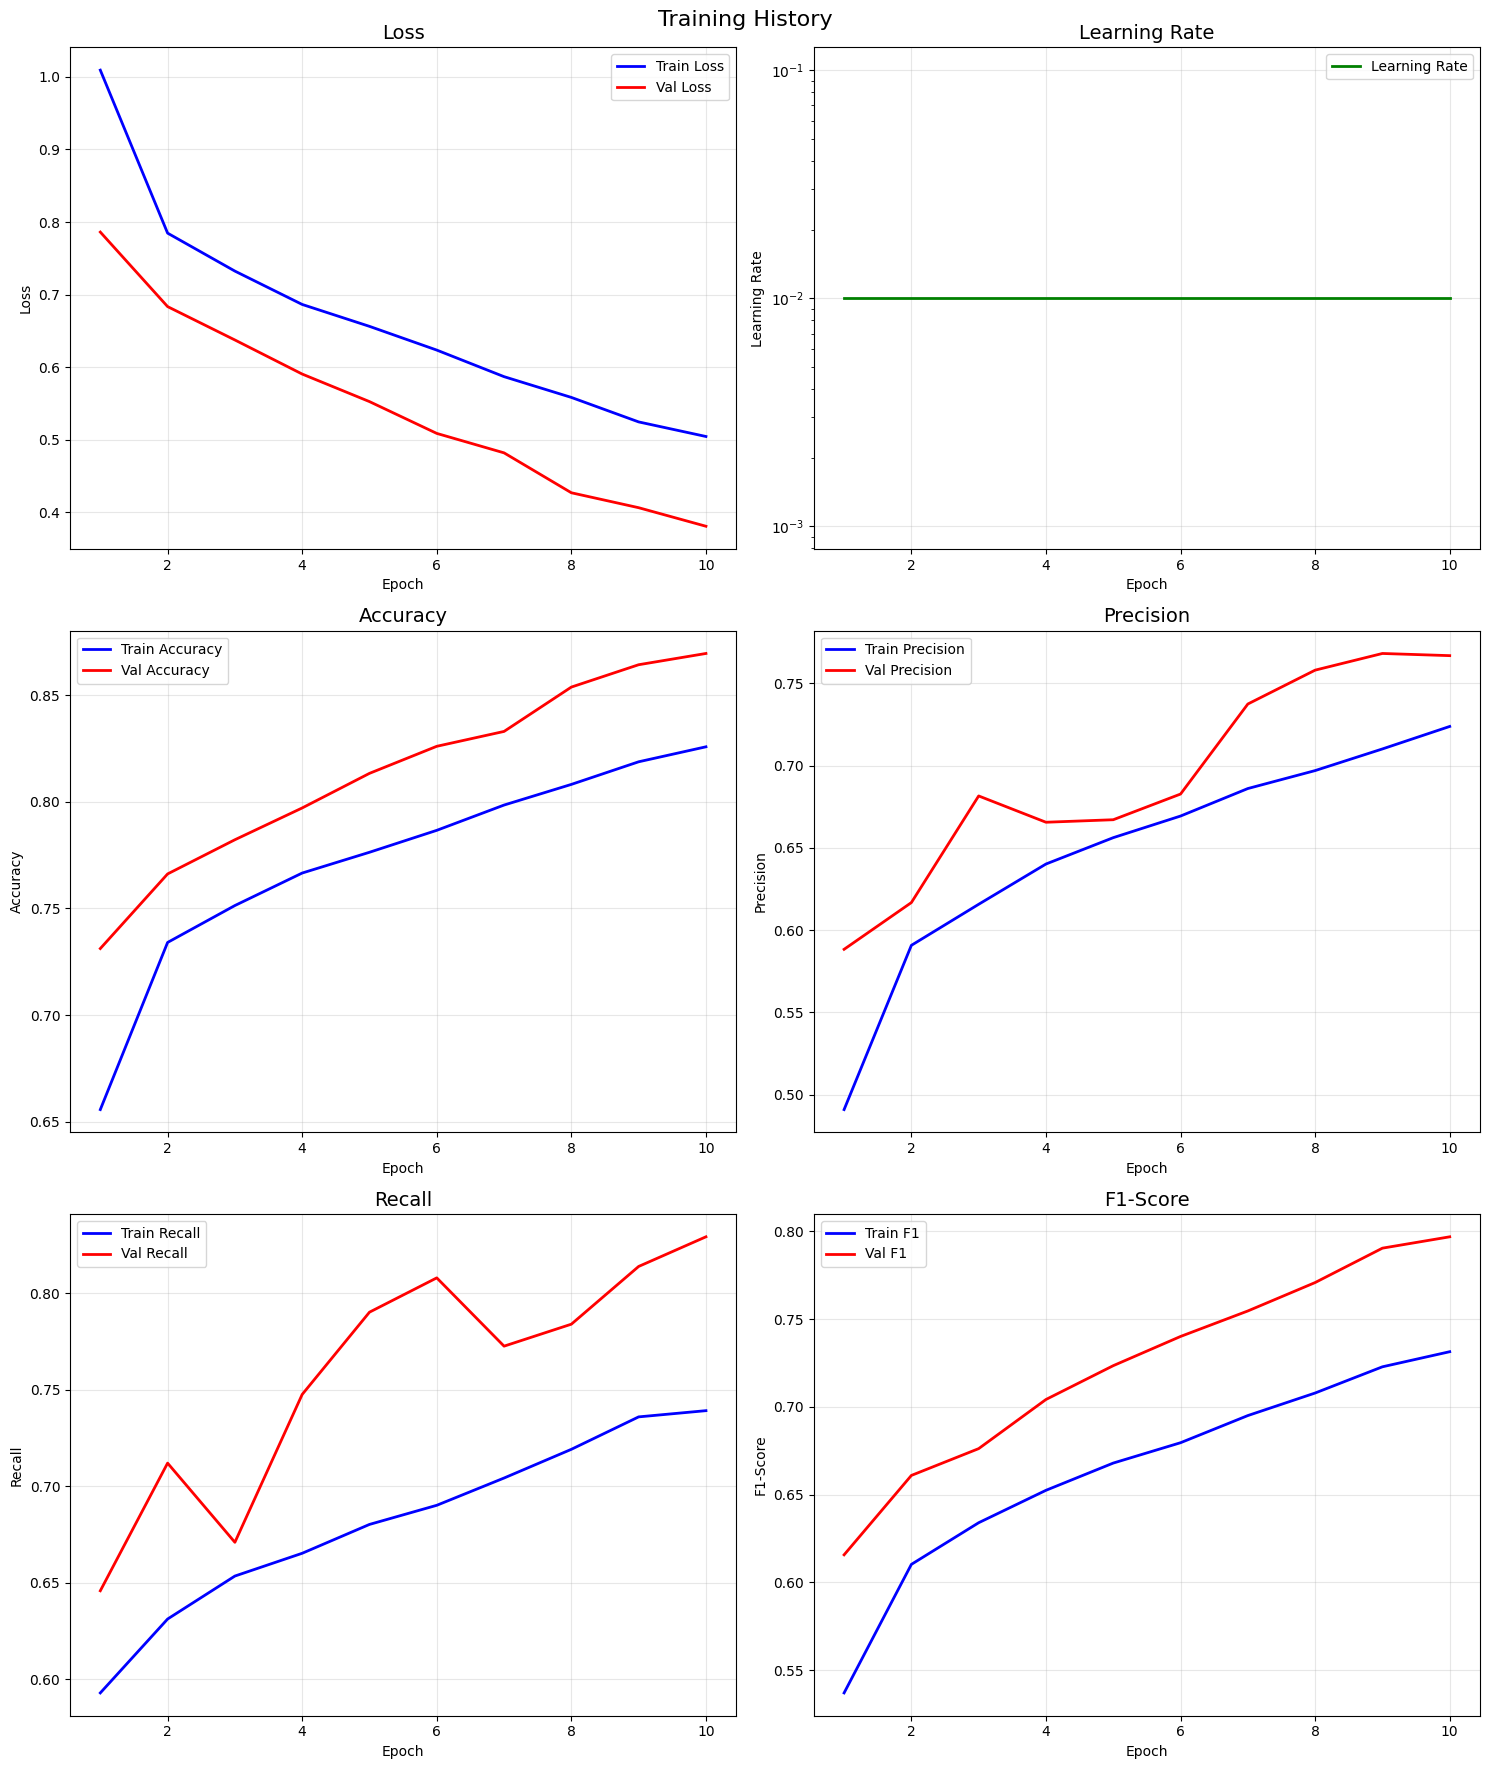

📈 Training plots saved to result_training_20250607_0943/training_history.png


best_epoch,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
final_learning_rate,▁
final_train_loss,▁
final_val_loss,▁
learning_rate,▁▁▁▁▁▁▁▁▁▁
lr_reductions,▁
train_accuracy,▁▄▅▆▆▆▇▇██
train_f1,▁▄▄▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁



🎉 Training completed!
Best model: Epoch 10 with val_loss: 0.3808
Final learning rate: 1.00e-02
Learning rate was reduced 0 times
Models saved in: model_checkpoints_20250607_0943
Results saved in: result_training_20250607_0943


In [35]:

# Example usage with custom scheduler parameters:

trained_model, train_losses, val_losses, train_metrics, val_metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    wandb_project = PROJECT_NAME, 
    run_name = RUN_NAME,
    scheduler_patience=SCH_PATIENCE,  # Wait 5 epochs before reducing LR
    scheduler_factor=SCH_FACTOR,  # Reduce LR by half
    scheduler_min_lr=0,  # Minimum learning rate
    scheduler_verbose=True  # Print when LR is reduced
)


Starting training...


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(



Epoch 1/10
Batch 0/76, Loss: 2.1486
Batch 10/76, Loss: 1.2266
Batch 20/76, Loss: 0.9330
Batch 30/76, Loss: 0.9034
Batch 40/76, Loss: 0.8004
Batch 50/76, Loss: 0.9412
Batch 60/76, Loss: 0.9521
Batch 70/76, Loss: 0.8663
🏆 New best model saved at epoch 1 with val_loss: 0.8148

Epoch 1 Results:
Train Loss: 1.0338 | Val Loss: 0.8148
Train Metrics:
  Accuracy:  0.6486
  Precision: 0.4952
  Recall:    0.5631
  F1-Score:  0.5270
Val Metrics:
  Accuracy:  0.7296
  Precision: 0.6272
  Recall:    0.5864
  F1-Score:  0.6061
------------------------------------------------------------

Epoch 2/10
Batch 0/76, Loss: 0.7314
Batch 10/76, Loss: 0.8417
Batch 20/76, Loss: 0.8333
Batch 30/76, Loss: 0.9149
Batch 40/76, Loss: 0.8910
Batch 50/76, Loss: 0.7459
Batch 60/76, Loss: 0.6871
Batch 70/76, Loss: 0.8357
🏆 New best model saved at epoch 2 with val_loss: 0.6971

Epoch 2 Results:
Train Loss: 0.7925 | Val Loss: 0.6971
Train Metrics:
  Accuracy:  0.7323
  Precision: 0.5869
  Recall:    0.6370
  F1-Score:  0

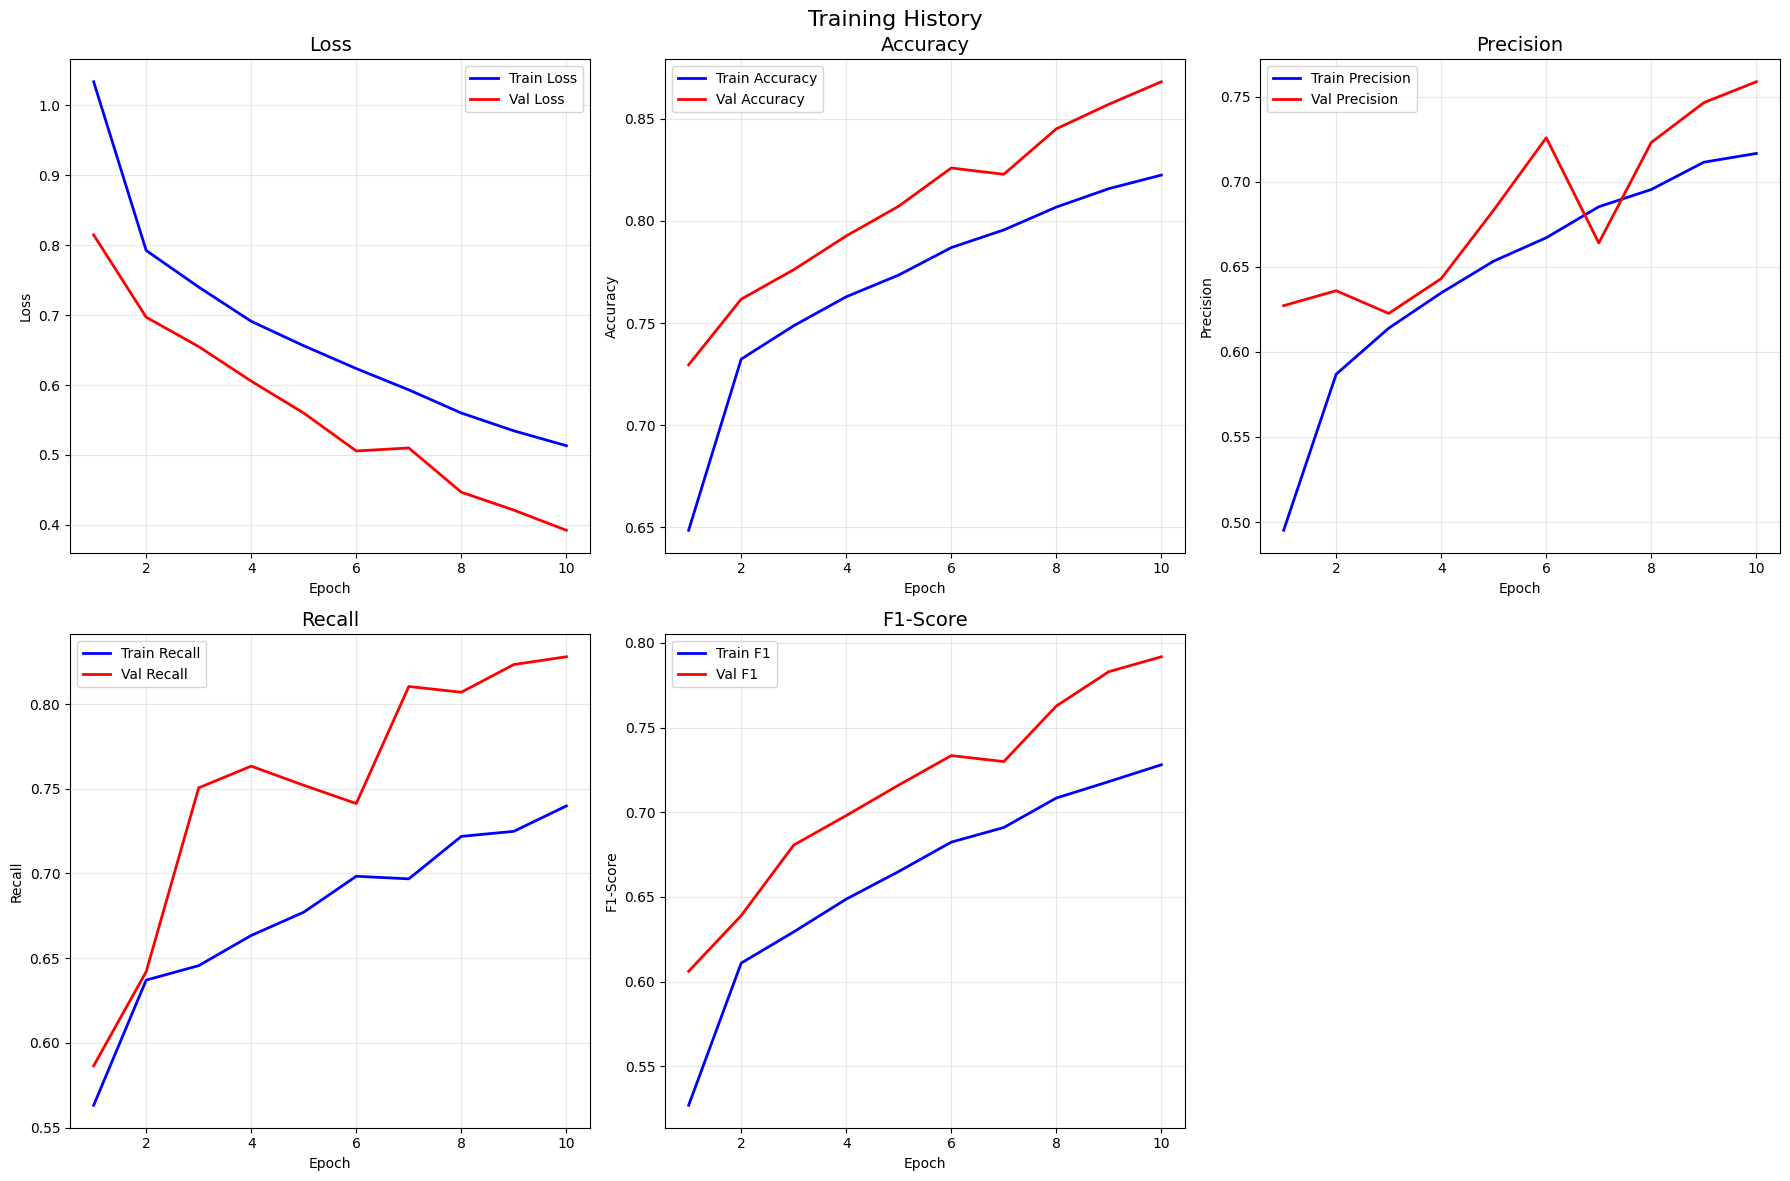

📈 Training plots saved to result_training_20250607_0903/training_history.png


best_epoch,▁
best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_f1,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
train_precision,▁▄▅▅▆▆▇▇██
train_recall,▁▄▄▅▆▆▆▇▇█
val_accuracy,▁▃▃▄▅▆▆▇▇█



🎉 Training completed!
Best model: Epoch 10 with val_loss: 0.3923
Models saved in: model_checkpoints_20250607_0903
Results saved in: result_training_20250607_0903
Training completed!
Final train loss: 0.5133
Final val loss: 0.3923


In [26]:

# Train the model
print("Starting training...")
trained_model, train_losses, val_losses, train_metrics, val_metrics = train_model(
        model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
        wandb_project = PROJECT_NAME, run_name = RUN_NAME
    )

print("Training completed!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")


# Training and Evaluation

In [27]:
# trainer.train()

In [28]:
# def confusion_matrix_func(y_pred, y_test, num_classes = 9):
#     confusion_matrix = [[0 for column in range(num_classes)] for rows in range(num_classes)]
#     class_invalid = np.zeros(num_classes)

#     for seq_number in range(len(y_test)):
#         for seq_pos in range (len(y_test[seq_number])):
#             if(not np.array_equal(class_invalid, y_test[seq_number][seq_pos])):
#                 actual_class = np.argmax(y_test[seq_number][seq_pos])
#                 predicted_class = np.argmax(y_pred[seq_number][seq_pos])

#                 confusion_matrix[actual_class][predicted_class] += 1
#     return confusion_matrix

In [29]:
# import numpy as np

# def confusion_matrix_report(matrix, labels=None):
#     """
#     Generate a comprehensive confusion matrix report with precision, recall, and Q-metrics.
    
#     Parameters:
#     - matrix: numpy array, the confusion matrix
#     - labels: list, custom class labels (if None, will use numeric indices)
    
#     Returns:
#     - metrics_dict: dictionary containing all calculated metrics
#     """
#     if labels is None:
#         labels = [str(i) for i in range(len(matrix))]
    
#     # Calculate Q metrics
#     n_classes = len(matrix)
#     total = np.sum(matrix)
#     correct = np.trace(matrix)
    
    
#     # Calculate sums for precision and recall
#     col_sums = np.sum(matrix, axis=0)  # Sum each column (for precision)
#     row_sums = np.sum(matrix, axis=1)  # Sum each row (for recall)
    
#     # Fix division by zero issues
#     col_sums[col_sums == 0] = 1
#     row_sums[row_sums == 0] = 1
    
#     # Calculate precision and recall for each class
#     precision = np.zeros(n_classes)
#     recall = np.zeros(n_classes)
    
#     for i in range(n_classes):
#         precision[i] = matrix[i, i] / col_sums[i]
#         recall[i] = matrix[i, i] / row_sums[i]

#     accuracy = np.trac(matrix)/np.sum(matrix)
#     # Store metrics in dictionary
#     metrics_dict = {
#         'precision': precision,
#         'recall': recall
#     }
    
#     # Print the confusion matrix
#     print("\n\033[4m\033[1mCONFUSION MATRIX\033[0m\033[0m")
    
#     # Print header with predicted labels
#     header = "\n\t\t\tPREDICTED\n\n\t" + "\t".join(labels)
#     print(header)
    
#     # Print each row with actual label and values
#     for i in range(n_classes):
#         row_values = "\t".join([str(num) for num in matrix[i]])
#         print(f"\n{labels[i]}\t{row_values}")
    
#     # Print Q metrics
#     print(f"\n\nQ{num_classes-1} Accuracy: {accuracy:.4f}")
    
#     # Print precision for each class
#     print("\nPrecision:")
#     for i in range(n_classes):
#         print(f"Precision {labels[i]}: {precision[i]:.4f}")
    
#     # Print recall for each class
#     print("\nRecall:")
#     for i in range(n_classes):
#         print(f"Recall {labels[i]}: {recall[i]:.4f}")
    
#     return metrics_dict



In [30]:
# # Example usage:
# if __name__ == "__main__":
#     # Example confusion matrix for 8 classes (similar to the original code with L, B, E, G, I, H, S, T)
#     example_matrix = np.array([
#         [85, 3, 0, 5, 0, 2, 1, 0],  # L
#         [7, 90, 1, 0, 0, 0, 0, 2],  # B
#         [0, 1, 75, 8, 5, 0, 5, 0],  # E
#         [4, 0, 6, 79, 3, 2, 1, 0],  # G
#         [0, 0, 7, 4, 82, 3, 1, 0],  # I
#         [1, 0, 0, 1, 6, 88, 2, 0],  # H
#         [3, 0, 4, 1, 1, 1, 80, 5],  # S
#         [0, 3, 0, 0, 0, 0, 4, 84]   # T
#     ])
    
#     # Define class labels
#     class_labels = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
    
#     # Generate the report
#     metrics = confusion_matrix_report(example_matrix, class_labels)